   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

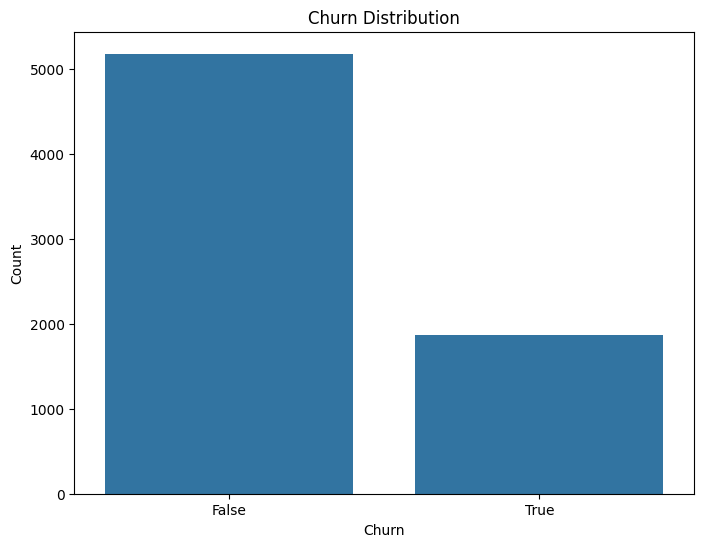

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Step 1: Load and preprocess the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Display the first few rows and basic information
print(df.head())
print(df.info())

# Check column names to find the correct column name for Churn
print("Columns in the dataset:", df.columns)

# Handle missing data
print("Missing values before handling:")
print(df.isnull().sum())

# Convert TotalCharges to numeric and fill missing values with median
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Display the column names after one-hot encoding
print("Columns after one-hot encoding:", df.columns)

# Attempt to find the correct column name for the target variable (Churn)
possible_churn_columns = [col for col in df.columns if 'churn' in col.lower()]
if len(possible_churn_columns) == 1:
    churn_column = possible_churn_columns[0]
    print(f"Identified churn column: {churn_column}")
else:
    raise KeyError("Unable to identify the churn column. Please check the column names.")

# Display summary statistics and churn distribution
print(df.describe())
print(df[churn_column].value_counts())

# Visualize churn distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=churn_column, data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Step 2: Feature engineering (if applicable)
# Example: Create a feature combining tenure and MonthlyCharges if they exist
if 'tenure' in df.columns and 'MonthlyCharges' in df.columns:
    df['Tenure_MonthlyCharges_Ratio'] = df['tenure'] / df['MonthlyCharges']

# Step 3: Model selection and training
# Split data into features (X) and target (y)
X = df.drop([churn_column], axis=1)
y = df[churn_column]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model (Random Forest Classifier)
rf = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_rf = grid_search.best_estimator_

# Step 4: Model evaluation
# Predict on the test set
y_pred = best_rf.predict(X_test_scaled)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set: {:.2f}%".format(accuracy * 100))

# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 5: Implementing the model in a real-world system
# Save the model using joblib
joblib.dump(best_rf, 'churn_prediction_model.pkl')

# Example of how to load the model and make predictions in a real-world application:
# loaded_model = joblib.load('churn_prediction_model.pkl')
# new_data = ...  # Load new customer data from your application
# prediction = loaded_model.predict(new_data)
# print("Predicted churn: ", prediction)



